In [1]:
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import chi2_contingency
import numpy as np
%matplotlib inline

# Introduction of dataset and data modelling problem

The dataset contains information about customers in Taiwan from April 2005 to September 2005 and their default status for the next month. Hence, our group is interested to find out how well are we able to accurately predict the customer's default status based on the attributes of the customers using a support vector machine model. To find out attributes that we feel would be relavant in predicting the default status of the model, we will conduct an exploratory data analysis first.

In [2]:
df = pd.read_csv("card.csv", sep = ",", skiprows = 1)


In [3]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [4]:
random.seed(1234)
n = len(df.index)
index = list(range(0,n))
testindex = random.sample(index, math.trunc(n / 4))
trainindex = [x for x in index if x not in testindex]
test_data = df.loc[df.index[testindex]]
train_data = df.loc[df.index[trainindex]]
default_df = df[df["default payment next month"] == 1]

# Exploratory Data Analysis

## Checking for missing values

In [5]:
df.isnull().any()

ID                            False
LIMIT_BAL                     False
SEX                           False
EDUCATION                     False
MARRIAGE                      False
AGE                           False
PAY_0                         False
PAY_2                         False
PAY_3                         False
PAY_4                         False
PAY_5                         False
PAY_6                         False
BILL_AMT1                     False
BILL_AMT2                     False
BILL_AMT3                     False
BILL_AMT4                     False
BILL_AMT5                     False
BILL_AMT6                     False
PAY_AMT1                      False
PAY_AMT2                      False
PAY_AMT3                      False
PAY_AMT4                      False
PAY_AMT5                      False
PAY_AMT6                      False
default payment next month    False
dtype: bool

In [6]:
df.isnull().any().sum()

0

After checking for null values in our dataset, we found that there are no missing values within our data set.

## Checking to see how many individuals will default the next month

In [7]:
df["default payment next month"].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [8]:
default_perc = 6636 / 30000
non_default_perc = 1 - default_perc
print("default_perc :", default_perc)
print("non-default_perc :", non_default_perc)


default_perc : 0.2212
non-default_perc : 0.7787999999999999


In the entire dataset, 22.1% of the customers default while 77.8% of the customers did not default.

## Feature columns in the dataset

There are 24 feature columns in the dataset.

## Summary Statistics for Age

In [9]:
df["AGE"].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

<AxesSubplot:xlabel='AGE', ylabel='Count'>

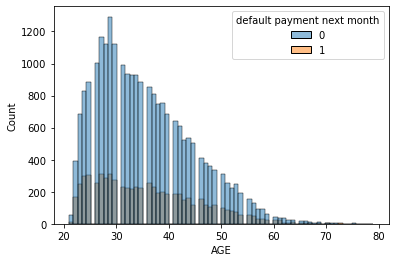

In [10]:
sns.histplot(data=df, x="AGE", hue="default payment next month")


From the histogram, it seems that there is a greater percentage of indivuals belonging to the age group of 20-40 to default. We will consider performing data pre processing on this category for the data to be easier to understand.

In [11]:
print(kurtosis(df["AGE"], fisher=False))
print(skew(df["AGE"], bias=False))

3.044096001350455
0.7322458687830563


Kurtosis is greater than 3 so the distribution of AGE is leptokurtic
Skew is greater than 0 so the distribution of AGE has a slightly thicker right tail

In [12]:
def draw_histplots(df, variables, rows, columns, max = 0):
    fig= plt.figure(figsize=(15, 5))
    fig.suptitle("Histogram PLOT")
    for i, cat_name in enumerate(variables):
        if (cat_name == "default payment next month"):
            break
        ax=fig.add_subplot(rows,columns,i+1)
        ax.set_xlim(0,max)
        sns.histplot(ax= ax, x= cat_name, hue="default payment next month", data= df)
        ax.set_title(cat_name)
    fig.tight_layout()  
    plt.show()

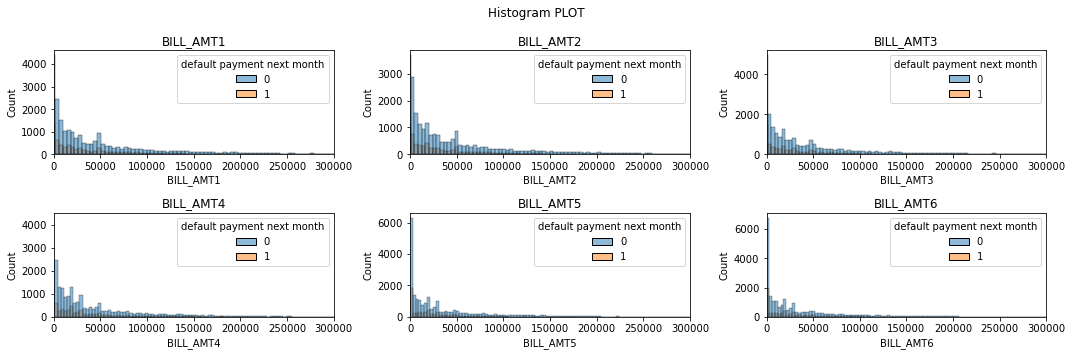

In [13]:
bill_df = df[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "default payment next month"]]
draw_histplots(bill_df, bill_df.columns, 2,3, max = 300_000)

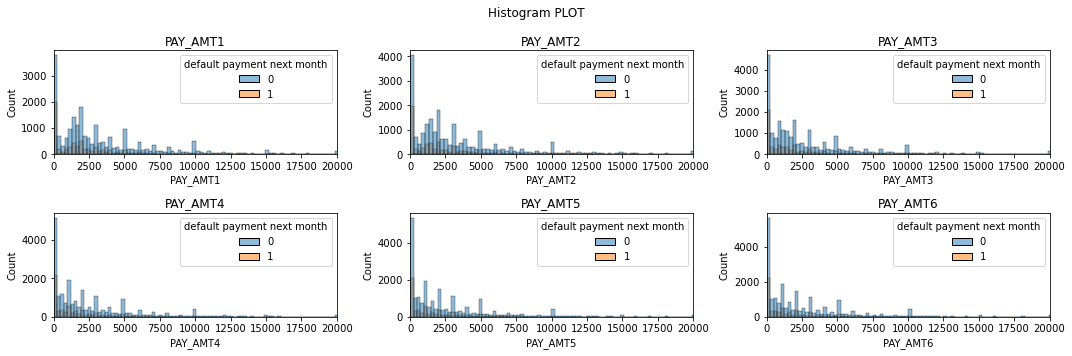

In [14]:
payamt_df = df[["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6", "default payment next month"]]
draw_histplots(payamt_df, payamt_df.columns, 2,3, 20000)

In [15]:
df["LIMIT_BAL"].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [16]:
print(kurtosis(df["LIMIT_BAL"], fisher=False))
print(skew(df["LIMIT_BAL"], bias = False))

3.5359735300865474
0.9928669605195439


Kurtosis is greater than 3 so the distribution of LIMIT_BAL is leptokurtic
Skew is greater than 0 so the distribution of LIMIT_BAL has a slightly thicker right tail

<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Count'>

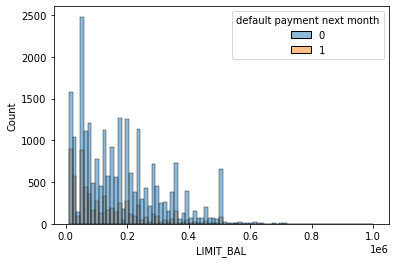

In [17]:
sns.histplot(df,x = "LIMIT_BAL", hue = "default payment next month")

From the histogram, we can see that more people default when their limit_bal is between 0 and 0.2 * 10^6. We will conduct data discretization to reduce the number of distinct values assumed by categorical variables.


## Anomalies and Inconsistencies in the dataset

### Anomalies in dataset

<AxesSubplot:xlabel='EDUCATION', ylabel='count'>

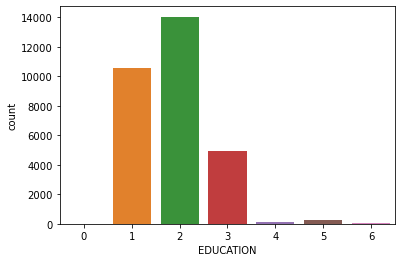

In [18]:
df["EDUCATION"].astype("category").nunique()
df['EDUCATION'] = df['EDUCATION'].astype('category')
sns.countplot(data = df, x= "EDUCATION")

In [19]:
len(df[df['EDUCATION'] == 0 ])

14

There are 14 rows of data that have EDUCATION coded as 0 which was not explained by the author. Hence, we do not know whether the extra values was a typographical error or it means another form of education level that they author did not explain.

<AxesSubplot:xlabel='MARRIAGE', ylabel='count'>

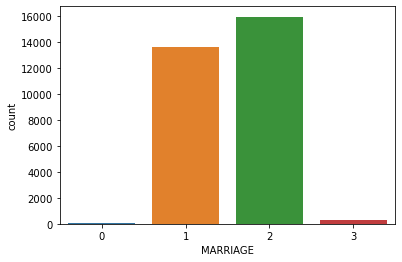

In [20]:
df['MARRIAGE'] = df['MARRIAGE'].astype('category')
sns.countplot(data = df, x= "MARRIAGE")

In [21]:
df["MARRIAGE"].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Similarly, the MARRIAGE variable also has an extra possible value that is 0 which was also not explained by the author. There are 54 rows of data that have MARRIAGE encoded as 0.

In [22]:
def draw_countplots(df, variables, rows, columns):
    fig= plt.figure(figsize=(15, 5))
    fig.suptitle("COUNT PLOT")
    for i, cat_name in enumerate(variables):
        ax=fig.add_subplot(rows,columns,i+1)
        sns.countplot(ax= ax, x= cat_name, data= df)
        ax.set_title(cat_name)
    fig.tight_layout()  
    plt.show()

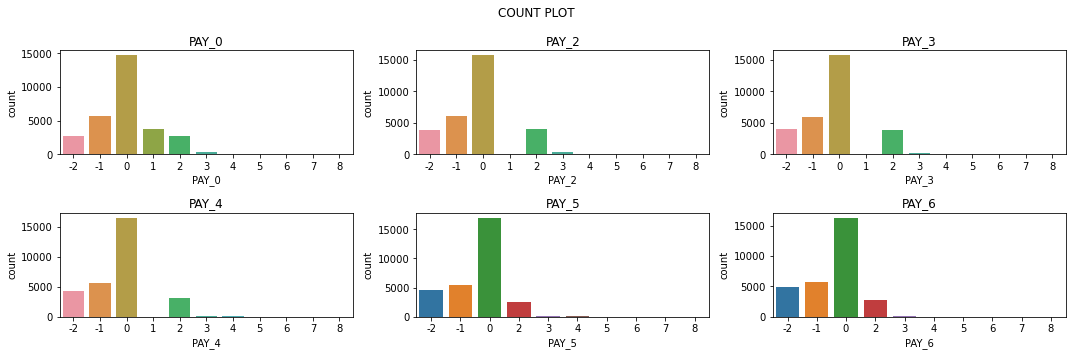

In [23]:
pay_df = df[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]]
draw_countplots(pay_df, pay_df.columns, 2,3)

In [24]:
len(df[df["PAY_0"] == 0])

14737

In [25]:
len(df[df["PAY_0"] == 0]) / len(df)

0.49123333333333336

We can observe that there are extra values that the repayment status in our dataset that can take on. Specifically, we see that the repayment status can be 0 or -2 which was not explained in the dataset description. Furthermore, there are many rows that have these extra values. For example in PAY_0 alone there are already 14737 rows of data that have PAY_0 being encoded as 0 which is already about 50% of the entire dataset. Therefore, we should not filter out all the data that have these extra values encoded since that would mean that our the size of our dataset will reduce dramatically. Given that there are many rows of data that contains values that were not explained, we need to perform data cleaning and pre-processing later before starting to train our model.

In [26]:
df["SEX"].astype("category").value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

No unexplained encodings observed for "Sex"

## Data cleaning and preprocessing

We have seen from our exploratory data analysis that there are several values that were not explained and many rows in the dataset contain such values. Hence, we decide to see if we are able to encode these values to another value that makes sense for our dataset.

### Repayment Status

Since the value in repayment status represents the number of months for payment delay, our group feels that 0 and -2 should also means that there 0 months in payment delay. Hence, our group decides to enocde 0 and -2 to -1 which represents duly payments.

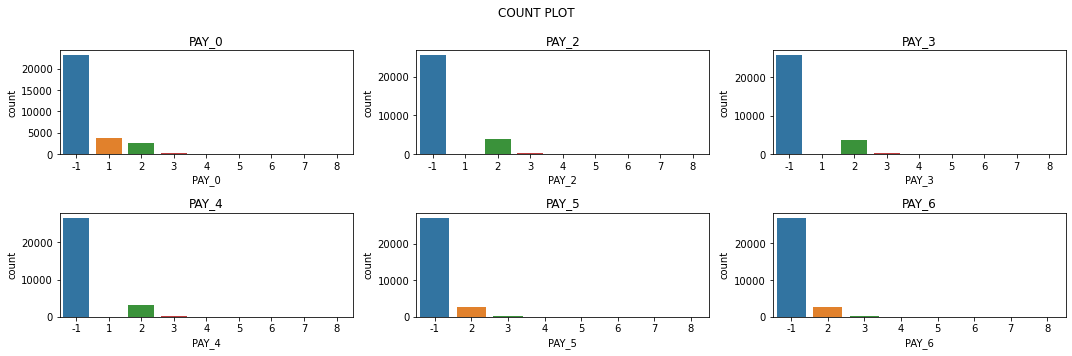

In [27]:
repayment_list = [df.PAY_0,df.PAY_2,df.PAY_3,df.PAY_4,df.PAY_5,df.PAY_6]
filter_list = []
names = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
for r in repayment_list:
    filter_list.append((r == -2) | (r  == -1) | (r == 0))
i = 0
for filter_obj in filter_list:
    df.loc[filter_obj, names[i]] = -1
    i+=1
pay_df = df[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]]
draw_countplots(pay_df, pay_df.columns, 2,3)

In [28]:
df["LATE"] = df["PAY_0"] > -1

In [29]:
df["LATE"] = df["LATE"].astype(int)

Our group decides to create a feature labelled as "LATE" to separate customers into two groups for simpler understanding. The two main groups are individuals who have been late in their payment before and those who have never been late before. We feel that there is a greater tendency for individuals who have been late in their payments to default as they may be experiencing some financial difficulties in their life.

### Education and Marriage 

In [30]:
filtered_education = (df.EDUCATION == 0)| (df.EDUCATION == 6) | (df.EDUCATION == 5)
df.loc[filtered_education, 'EDUCATION'] = 4
filtered_marriage = (df.MARRIAGE == 0)
df.loc[filtered_marriage, 'MARRIAGE'] = 3

Since the value 5 and 6 for Education is unknown and value of 0 for Education is not explained, our group decides to group all of them under value 4 which is 'others'. For the value 0 under Marriage, we decide to group them under value 3 which is "others".

### Age

In [31]:
def conditions_age(df):
    if (df['AGE'] > 20) and (df["AGE"] <= 40):
        return 1
    elif (df["AGE"] > 40 and df["AGE"] <= 60):
        return 2
    else:
        return 3

df["NEW_AGE"] = df.apply(conditions_age, axis=1)

Age > 20 and Age <= 40 : 1
Age > 40 and Age <= 60 : 2
Age > 60  3
this is for data discretization

### Limit Bal

In [32]:
def conditions_limit(df):
    if (df['LIMIT_BAL'] > 0) and (df["LIMIT_BAL"] <= 200_000):
        return 1
    elif (df["LIMIT_BAL"] > 200_000 and df["LIMIT_BAL"] <= 400_000):
        return 2
    else:
        return 3

df["NEW_LIMIT_BAL"] = df.apply(conditions_limit, axis=1)

LIMIT_BAL > 0 and LIMIT_BAL <= 200 000  : 1
LB > 200 000 and LB  <= 400 000 : 2
LB > 400 000  3
same as age

## Checking for trends after data preprocessing

### Countplot for individuals who have been late in their payment before

<AxesSubplot:xlabel='LATE', ylabel='count'>

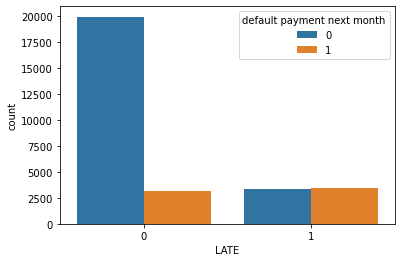

In [33]:
sns.countplot(data = df, x = "LATE", hue = "default payment next month")

In [34]:
# late is 0 and defaults
LATE_0_defaults = len(df[(df["LATE"] == 0) & (df["default payment next month"] == 1)])
LATE_0_defaults_perc = LATE_0_defaults / len(df[(df["LATE"] == 0)])
print(LATE_0_defaults_perc)


# late is 1 and defaults
LATE_1_defaults = len(df[(df["LATE"] == 1) & (df["default payment next month"] == 1)])
LATE_1_defaults_perc = LATE_1_defaults / len(df[(df["LATE"] == 1)])
print(LATE_1_defaults_perc)

0.13834009145026313
0.5029334115576415


From the graph we can see that a greater percentage of those who have been late in their payments before to default in the next month. It seems that this feature will useful in predicting whether customer will default.

### Countplot for individuals based on their marriage status

<AxesSubplot:xlabel='MARRIAGE', ylabel='count'>

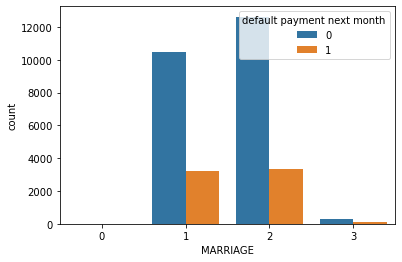

In [35]:
sns.countplot(data = df, x = "MARRIAGE", hue = "default payment next month")

In [36]:
# marriage is 1 and defaults
MARRIAGE_1_defaults = len(df[(df["MARRIAGE"] == 1) & (df["default payment next month"] == 1)])
MARRIAGE_1_defaults_perc = MARRIAGE_1_defaults / len(df[(df["MARRIAGE"] == 1)])
print(MARRIAGE_1_defaults_perc)


# marriage is 2 and defaults
MARRIAGE_2_defaults = len(df[(df["MARRIAGE"] == 2) & (df["default payment next month"] == 1)])
MARRIAGE_2_defaults_perc = MARRIAGE_2_defaults / len(df[(df["MARRIAGE"] == 2)])
print(MARRIAGE_2_defaults_perc)

# marriage is 3 and defaults
MARRIAGE_3_defaults = len(df[(df["MARRIAGE"] == 3) & (df["default payment next month"] == 1)])
MARRIAGE_3_defaults_perc = MARRIAGE_3_defaults / len(df[(df["MARRIAGE"] == 3)])
print(MARRIAGE_3_defaults_perc)



0.23471703638626545
0.20928338762214985
0.23607427055702918


Not much differences

### Countplot for individuals based on their sex

<AxesSubplot:xlabel='SEX', ylabel='count'>

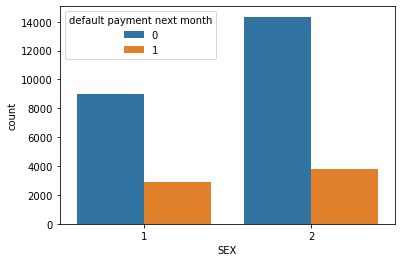

In [37]:
sns.countplot(data = df, x = "SEX", hue = "default payment next month")

In [38]:
# sex is male and defaults
sex_1_defaults = len(df[(df["SEX"] == 1) & (df["default payment next month"] == 1)])
sex_1_defaults_perc = sex_1_defaults / len(df[(df["SEX"] == 1)])
print(sex_1_defaults_perc)

# sex is female and defaults
sex_2_defaults = len(df[(df["SEX"] == 2) & (df["default payment next month"] == 1)])
sex_2_defaults_perc = sex_2_defaults / len(df[(df["SEX"] == 2)])
print(sex_2_defaults_perc)

0.2416722745625841
0.20776280918727916


Overall, it seems that individuals who are male are more likely to default than females. Hence, the gender of the customer could be useful in predicting customer default status.

### Countplot for individuals based on their education

<AxesSubplot:xlabel='EDUCATION', ylabel='count'>

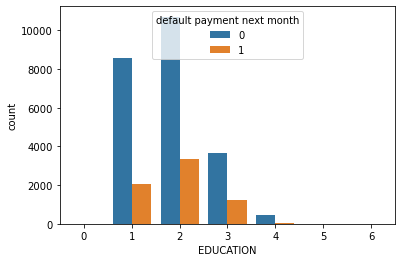

In [39]:
sns.countplot(data = df, x = "EDUCATION", hue = "default payment next month")

In [40]:
# education is 1 and defaults
edu_1_defaults = len(df[(df["EDUCATION"] == 1) & (df["default payment next month"] == 1)])
edu_1_defaults_perc = edu_1_defaults / len(df[(df["EDUCATION"] == 1)])
print(edu_1_defaults_perc)


# education is 2 and defaults
edu_2_defaults = len(df[(df["EDUCATION"] == 2) & (df["default payment next month"] == 1)])
edu_2_defaults_perc = edu_2_defaults / len(df[(df["EDUCATION"] == 2)])
print(edu_2_defaults_perc)

# education is 3 and defaults
edu_3_defaults = len(df[(df["EDUCATION"] == 3) & (df["default payment next month"] == 1)])
edu_3_defaults_perc = edu_3_defaults / len(df[(df["EDUCATION"] == 3)])
print(edu_3_defaults_perc)

# education is 4 and defaults
edu_4_defaults = len(df[(df["EDUCATION"] == 4) & (df["default payment next month"] == 1)])
edu_4_defaults_perc = edu_4_defaults / len(df[(df["EDUCATION"] == 4)])
print(edu_4_defaults_perc)

0.19234766178554558
0.23734853884533144
0.2515761643278422
0.07051282051282051


From the graph and based on our further calculations, it seems that there is a higher percentage of individuals with an education level of high school to default. This feature could also be useful for our model.

<AxesSubplot:xlabel='NEW_AGE', ylabel='count'>

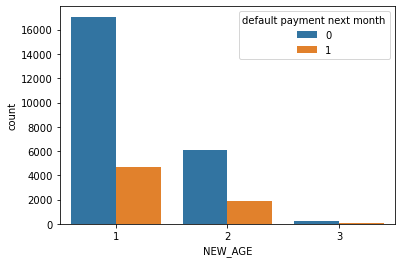

In [41]:
sns.countplot(data = df, x = "NEW_AGE", hue = "default payment next month")

In [42]:
# AGE is 1 and defaults
age_1_defaults = len(df[(df["NEW_AGE"] == 1) & (df["default payment next month"] == 1)])
age_1_defaults_perc = age_1_defaults / len(df[(df["NEW_AGE"] == 1)])
print(age_1_defaults_perc)


# AGE is 2 and defaults
age_2_defaults = len(df[(df["NEW_AGE"] == 2) & (df["default payment next month"] == 1)])
age_2_defaults_perc = age_2_defaults / len(df[(df["NEW_AGE"] == 2)])
print(age_2_defaults_perc)

# AGE is 3 and defaults
age_3_defaults = len(df[(df["NEW_AGE"] == 3) & (df["default payment next month"] == 1)])
age_3_defaults_perc = age_3_defaults / len(df[(df["NEW_AGE"] == 3)])
print(age_3_defaults_perc)

0.2144895516892203
0.23781554611347164
0.26838235294117646


percentage is quite similar for all age groups.

<AxesSubplot:xlabel='NEW_LIMIT_BAL', ylabel='count'>

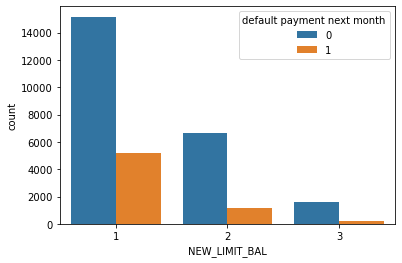

In [43]:
sns.countplot(data = df, x = "NEW_LIMIT_BAL", hue = "default payment next month")

In [44]:
# NLB is 1 and defaults
nlb_1_defaults = len(df[(df["NEW_LIMIT_BAL"] == 1) & (df["default payment next month"] == 1)])
nlb_1_defaults_perc = nlb_1_defaults / len(df[(df["NEW_LIMIT_BAL"] == 1)])
print(nlb_1_defaults_perc)


# NLB is 2 and defaults
nlb_2_defaults = len(df[(df["NEW_LIMIT_BAL"] == 2) & (df["default payment next month"] == 1)])
nlb_2_defaults_perc = nlb_2_defaults / len(df[(df["NEW_LIMIT_BAL"] == 2)])
print(nlb_2_defaults_perc)

# NLB is 3 and defaults
nlb_3_defaults = len(df[(df["NEW_LIMIT_BAL"] == 3) & (df["default payment next month"] == 1)])
nlb_3_defaults_perc = nlb_3_defaults / len(df[(df["NEW_LIMIT_BAL"] == 3)])
print(nlb_3_defaults_perc)

0.2561095298851703
0.15349194167306215
0.12028824833702882


People who have limit balance of 0 to 200 000 have a much higher percentage of default compared to other groups.

## Feature Selection

In [45]:
# SEX
print(df["SEX"].value_counts())
print(df[(df["SEX"] == 1) & (df["default payment next month"] == 1)]["SEX"].value_counts())
print(df[(df["SEX"] == 2) & (df["default payment next month"] == 1)]["SEX"].value_counts())
print(df[(df["SEX"] == 1) & (df["default payment next month"] == 0)]["SEX"].value_counts())
print(df[(df["SEX"] == 2) & (df["default payment next month"] == 0)]["SEX"].value_counts())


2    18112
1    11888
Name: SEX, dtype: int64
1    2873
Name: SEX, dtype: int64
2    3763
Name: SEX, dtype: int64
1    9015
Name: SEX, dtype: int64
2    14349
Name: SEX, dtype: int64


2873 -> SEX = 1 and default
3763 -> SEX = 2 and default
9015 -> SEX = 1 and no default
14349 -> SEX = 2 and no default

In [46]:
tab_data = [[2873, 3763], [9015, 14349]]
chi2_contingency(tab_data)

(47.70879689062111,
 4.944678999412044e-12,
 1,
 array([[ 2629.6256,  4006.3744],
        [ 9258.3744, 14105.6256]]))

In [47]:
# EDUCATION
print(df["EDUCATION"].value_counts())
print(len(df[(df["EDUCATION"] == 1) & (df["default payment next month"] == 1)]))
print(len(df[(df["EDUCATION"] == 2) & (df["default payment next month"] == 1)]))
print(len(df[(df["EDUCATION"] == 3) & (df["default payment next month"] == 1)]))
print(len(df[(df["EDUCATION"] == 4) & (df["default payment next month"] == 1)]))


print(len(df[(df["EDUCATION"] == 1) & (df["default payment next month"] == 0)]))
print(len(df[(df["EDUCATION"] == 2) & (df["default payment next month"] == 0)]))
print(len(df[(df["EDUCATION"] == 3) & (df["default payment next month"] == 0)]))
print(len(df[(df["EDUCATION"] == 4) & (df["default payment next month"] == 0)]))


2    14030
1    10585
3     4917
4      468
0        0
5        0
6        0
Name: EDUCATION, dtype: int64
2036
3330
1237
33
8549
10700
3680
435


In [48]:
tab_data_EDUCATION = [[2036,3330,1237,33], [8549,10700,3680,435]]
chi2, p, dof, ex =  chi2_contingency(tab_data_EDUCATION)
p

1.495064564810615e-34

In [49]:
# MARRIAGE
print(df["MARRIAGE"].value_counts())
print(len(df[(df["MARRIAGE"] == 1) & (df["default payment next month"] == 1)]))
print(len(df[(df["MARRIAGE"] == 2) & (df["default payment next month"] == 1)]))
print(len(df[(df["MARRIAGE"] == 3) & (df["default payment next month"] == 1)]))

print(len(df[(df["MARRIAGE"] == 1) & (df["default payment next month"] == 0)]))
print(len(df[(df["MARRIAGE"] == 2) & (df["default payment next month"] == 0)]))
print(len(df[(df["MARRIAGE"] == 3) & (df["default payment next month"] == 0)]))


2    15964
1    13659
3      377
0        0
Name: MARRIAGE, dtype: int64
3206
3341
89
10453
12623
288


In [50]:
tab_data_MARRIAGE = [[3206,3341,89], [10453,12623,288]]
chi2, p, dof, ex =  chi2_contingency(tab_data_MARRIAGE)
p

7.790720364202813e-07

In [51]:
# NEW_LIMIT_BAL
print(df["NEW_LIMIT_BAL"].value_counts())
print(len(df[(df["NEW_LIMIT_BAL"] == 1) & (df["default payment next month"] == 1)]))
print(len(df[(df["NEW_LIMIT_BAL"] == 2) & (df["default payment next month"] == 1)]))
print(len(df[(df["NEW_LIMIT_BAL"] == 3) & (df["default payment next month"] == 1)]))

print(len(df[(df["NEW_LIMIT_BAL"] == 1) & (df["default payment next month"] == 0)]))
print(len(df[(df["NEW_LIMIT_BAL"] == 2) & (df["default payment next month"] == 0)]))
print(len(df[(df["NEW_LIMIT_BAL"] == 3) & (df["default payment next month"] == 0)]))

1    20378
2     7818
3     1804
Name: NEW_LIMIT_BAL, dtype: int64
5219
1200
217
15159
6618
1587


In [52]:
tab_data_NLB = [[5219,1200,217], [15159,6618,1587]]
chi2, p, dof, ex =  chi2_contingency(tab_data_NLB)
p

2.3082716470487475e-100

In [53]:
# LATE
print(df["LATE"].value_counts())
print(len(df[(df["LATE"] == 0) & (df["default payment next month"] == 1)]))
print(len(df[(df["LATE"] == 1) & (df["default payment next month"] == 1)]))

print(len(df[(df["LATE"] == 0) & (df["default payment next month"] == 0)]))
print(len(df[(df["LATE"] == 1) & (df["default payment next month"] == 0)]))


0    23182
1     6818
Name: LATE, dtype: int64
3207
3429
19975
3389


In [54]:
tab_data_LATE = [[3207,3429], [19975,3389]]
chi2, p, dof, ex = chi2_contingency(tab_data_LATE)
p

0.0

In [55]:
# NEW_AGE
print(df["NEW_AGE"].value_counts())
print(len(df[(df["NEW_AGE"] == 1) & (df["default payment next month"] == 1)]))
print(len(df[(df["NEW_AGE"] == 2) & (df["default payment next month"] == 1)]))
print(len(df[(df["NEW_AGE"] == 3) & (df["default payment next month"] == 1)]))


print(len(df[(df["NEW_AGE"] == 1) & (df["default payment next month"] == 0)]))
print(len(df[(df["NEW_AGE"] == 2) & (df["default payment next month"] == 0)]))
print(len(df[(df["NEW_AGE"] == 3) & (df["default payment next month"] == 0)]))


1    21726
2     8002
3      272
Name: NEW_AGE, dtype: int64
4660
1903
73
17066
6099
199


In [56]:
tab_data_NEW_AGE = [[4660,1903,73], [17066,6099,199]]
chi2, p, dof, ex = chi2_contingency(tab_data_NEW_AGE)
p

1.6554284303886136e-05

All the p-values reported (for the features) are less than the p value of 0.05. Hence, the results are significant at p <  0.05 and we reject the H0 in favor of Ha. Hence, these feature variables may be useful input attributes in the model when we are trying to predict if the customer will default.


## Creating training set and test set for our model

In [57]:
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

In [58]:
random.seed(1234)
n = len(df.index)
index = list(range(0,n))
testindex = random.sample(index, math.trunc(n / 4))
trainindex = [x for x in index if x not in testindex]
test_data = df.loc[df.index[testindex]]
train_data = df.loc[df.index[trainindex]]

In [59]:
train_x = train_data[["SEX", "LATE", "EDUCATION","NEW_LIMIT_BAL", "NEW_AGE", "MARRIAGE"]]
train_y = train_data["default payment next month"]
test_x = test_data[["SEX", "LATE","EDUCATION","NEW_LIMIT_BAL",  "NEW_AGE", "MARRIAGE"]]
test_y = test_data["default payment next month"]

## Model Selection 

## SVM

In [60]:
param_grid = {'kernel': ('linear', 'rbf')}


In [61]:
svc = svm.SVC(random_state=0, class_weight= "balanced")
search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring="roc_auc", cv = 3)
search.fit(train_x, train_y)

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced', random_state=0),
             param_grid={'kernel': ('linear', 'rbf')}, scoring='roc_auc')

Setting class_weights = ‘balanced’, the model assigns the class weights inversely proportional to their respective frequencies.

In [62]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])

In [63]:
results_df["mean_test_score"]

0    0.712730
1    0.696309
Name: mean_test_score, dtype: float64

In [64]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.674502,0.012977,0.565239,0.004429,linear,{'kernel': 'linear'},0.697327,0.713879,0.726984,0.712730,0.012134,1
1,2.872576,0.167673,4.147433,0.044512,rbf,{'kernel': 'rbf'},0.683023,0.704573,0.701331,0.696309,0.009487,2


Based on the GridSearch result, we can conclude that the best parameter to choose is the linear kernel.

### Model evaluation

In [65]:
clf = svm.SVC(kernel='linear', class_weight='balanced') # Linear Kernel
clf.fit(train_x, train_y)

SVC(class_weight='balanced', kernel='linear')

In [66]:
y_pred = clf.predict(test_x)

In [67]:
confusion_matrix = metrics.confusion_matrix(test_y, y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()
confusion_matrix

array([[5029,  860],
       [ 793,  818]])

In [68]:
# Model Precision
print("Precision: ",metrics.precision_score(test_y, y_pred))

# Model Recall
print("Recall: ",metrics.recall_score(test_y, y_pred))

#Model Accuracy
print("Accuracy: ",metrics.accuracy_score(test_y, y_pred))

#f1-score
print("f1-score: ", metrics.f1_score(test_y, y_pred))

#misclassification rate
misclassification_rate = (fp + fn) / (fp + fn + tp + tn)
print("misclassification rate: ", misclassification_rate)

#sensitivity
sensitivity = (tp) / (fn + tp)
print("sensitivity: ", sensitivity)

#specificity
specificity = (tn) / (tn + fp)
print("specificity: ", specificity)

Precision:  0.48748510131108463
Recall:  0.5077591558038486
Accuracy:  0.7796
f1-score:  0.4974156278504105
misclassification rate:  0.2204
sensitivity:  0.5077591558038486
specificity:  0.8539650195279335


## Logistic Regression

In [69]:
parameters = {
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}

In [70]:
logreg = LogisticRegression(class_weight = "balanced")
search_logreg = GridSearchCV(logreg,                  
                   param_grid = parameters,
                   scoring="roc_auc",     
                   cv=10)  
search_logreg.fit(train_x, train_y)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

In [71]:
results_logreg_df = pd.DataFrame(search_logreg.cv_results_)
results_logreg_df = results_logreg_df.sort_values(by=["rank_test_score"])

In [72]:
results_logreg_df["mean_test_score"]
results_logreg_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.046753,0.008292,0.002345,0.002881,newton-cg,{'solver': 'newton-cg'},0.700115,0.711203,0.710299,0.695224,0.713758,0.743361,0.735079,0.732856,0.738173,0.733928,0.721400,0.016318,1
1,0.033027,0.002803,0.001229,0.000264,lbfgs,{'solver': 'lbfgs'},0.700115,0.711203,0.710299,0.695224,0.713758,0.743361,0.735079,0.732856,0.738173,0.733928,0.721400,0.016318,1
2,0.016963,0.004272,0.001373,0.000358,liblinear,{'solver': 'liblinear'},0.700110,0.711203,0.710299,0.695138,0.713734,0.743361,0.735078,0.732856,0.737945,0.733916,0.721364,0.016309,3


In [73]:
logreg = LogisticRegression(solver = "newton-cg")
logreg.fit(train_x,train_y)
y_pred_log = logreg.predict(test_x)
print("Accuracy:",metrics.accuracy_score(test_y, y_pred_log))

Accuracy: 0.7930666666666667


In [74]:
confusion_matrix = metrics.confusion_matrix(test_y, y_pred_log)
tn, fp, fn, tp = confusion_matrix.ravel()
confusion_matrix

array([[5443,  446],
       [1106,  505]])

In [75]:
# Model Precision
print("Precision: ",metrics.precision_score(test_y, y_pred_log))

# Model Recall
print("Recall: ",metrics.recall_score(test_y, y_pred_log))

#Model Accuracy
print("Accuracy: ",metrics.accuracy_score(test_y, y_pred_log))

#f1-score
print("f1-score: ", metrics.f1_score(test_y, y_pred_log))

#misclassification rate
misclassification_rate = (fp + fn) / (fp + fn + tp + tn)
print("misclassification rate: ", misclassification_rate)

#sensitivity
sensitivity = (tp) / (fn + tp)
print("sensitivity: ", sensitivity)

#specificity
specificity = (tn) / (tn + fp)
print("specificity: ", specificity)

Precision:  0.5310199789695058
Recall:  0.31346989447548107
Accuracy:  0.7930666666666667
f1-score:  0.3942232630757221
misclassification rate:  0.20693333333333333
sensitivity:  0.31346989447548107
specificity:  0.9242655798947189


## Decision Tree

In [76]:
from sklearn import tree

In [77]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_x, train_y)

In [78]:
y_pred_dtree = clf.predict(test_x)

In [79]:
confusion_matrix = metrics.confusion_matrix(test_y, y_pred_dtree)
tn, fp, fn, tp = confusion_matrix.ravel()
confusion_matrix

array([[5373,  516],
       [1044,  567]])

In [80]:
# Model Precision
print("Precision: ",metrics.precision_score(test_y, y_pred_dtree))

# Model Recall
print("Recall: ",metrics.recall_score(test_y, y_pred_dtree))

#Model Accuracy
print("Accuracy: ",metrics.accuracy_score(test_y, y_pred_dtree))

#f1-score
print("f1-score: ", metrics.f1_score(test_y, y_pred_dtree))

#misclassification rate
misclassification_rate = (fp + fn) / (fp + fn + tp + tn)
print("misclassification rate: ", misclassification_rate)

#sensitivity
sensitivity = (tp) / (fn + tp)
print("sensitivity: ", sensitivity)

#specificity
specificity = (tn) / (tn + fp)
print("specificity: ", specificity)

Precision:  0.5235457063711911
Recall:  0.35195530726256985
Accuracy:  0.792
f1-score:  0.4209354120267261
misclassification rate:  0.208
sensitivity:  0.35195530726256985
specificity:  0.9123790117167601


svm gives higher recall so higher true positive rate so should choose it since we want to determine those who defaults.

## Using ANN 


In [81]:
import torch
import torch.nn as nn
import numpy as np

In [82]:
# train_x = train_data[["SEX", "LATE", "EDUCATION","NEW_LIMIT_BAL", "NEW_AGE", "MARRIAGE"]]
# train_y = train_data["default payment next month"]
# test_x = test_data[["SEX", "LATE","EDUCATION","NEW_LIMIT_BAL",  "NEW_AGE", "MARRIAGE"]]
# test_y = test_data["default payment next month"]

In [83]:
def buildANNmodel():
    ANNclassify = nn.Sequential(
                  nn.Linear(6, 16),
                  nn.ReLU(),
                  nn.Linear(16,1),
                  nn.ReLU(),
                  nn.Linear(1,1),
                  nn.Sigmoid() )
    lossfun = nn.BCELoss()
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr = 0.1 )
    return ANNclassify, lossfun, optimizer
    

In [84]:
train_x_torch = torch.tensor(train_x.to_numpy().astype(np.float32))
train_y_torch = torch.tensor(train_y.to_numpy().astype(np.float32).reshape(22500,1))
test_x_torch = torch.tensor(test_x.to_numpy().astype(np.float32))
test_y_torch = torch.tensor(test_y.to_numpy().astype(np.float32).reshape(7500,1))


In [85]:
train_x_torch.dtype

torch.float32

In [86]:
numepochs = 1500
def train_model(ANNclassify):
    losses = torch.zeros(numepochs)
    for epoch_i in range(numepochs):
        
        #initialize losses
        yHat = ANNclassify(train_x_torch)
        
        #compute loss
        loss = lossfun(yHat, train_y_torch)
        losses[epoch_i] = loss
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    predictions = ANNclassify(train_x_torch)
    totalacc = 100 * torch.mean(((predictions > 0.5) == train_y_torch).float())
    
    return losses, predictions, totalacc, ANNclassify

        

In [87]:
ANNclassify, lossfun, optimizer = buildANNmodel()
losses, predictions, totalacc, model = train_model(ANNclassify)
print(f"final accuracy: {totalacc}")

final accuracy: 77.66666412353516


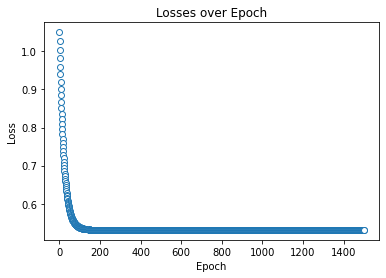

In [88]:
plt.plot(losses.detach(), 'o', markerfacecolor = 'w', linewidth = .1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Losses over Epoch")
plt.show()

## Performance of model for test set

In [ ]:
predYtest = ANNreg(x[~trainBool])
testloss = (predYtest-y[~trainBool]).pow(2).mean()

In [96]:
y_test_pred = model(test_x_torch)
totalacc_y_test = 100 * torch.mean(((y_test_pred > 0.5) == test_y_torch).float())
totalacc_y_test.float()

tensor(78.5200)